In [1]:
import os

root_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
os.chdir(root_dir)

In [2]:
# import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)
# sns.set_palette("Set2")
import functions

from multiprocessing import Pool
from functools import partial

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef

# from ipywidgets import interact
# import ipywidgets as widgets
from scipy.signal import savgol_filter

%load_ext autoreload
%autoreload 2



# Kyte & Doolittle index of hydrophobicity
# J. Mol. Biol. 157:105-132(1982).
kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
      "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
      "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
      "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2}

#Sort kd
kd = {k: v for k, v in sorted(kd.items(), key=lambda item: item[1])}

# Flexibility
# Normalized flexibility parameters (B-values), average
# Vihinen M., Torkkila E., Riikonen P. Proteins. 19(2):141-9(1994).
flexibilities_vih = {"A": 0.984, "C": 0.906, "E": 1.094, "D": 1.068,
"G": 1.031, "F": 0.915, "I": 0.927, "H": 0.950,
"K": 1.102, "M": 0.952, "L": 0.935, "N": 1.048,
"Q": 1.037, "P": 1.049, "S": 1.046, "R": 1.008,
"T": 0.997, "W": 0.904, "V": 0.931, "Y": 0.929}

def flex(seq):
    seq = seq.replace('U', 'C')
    if len(seq) == 0:
        return 0
    else:
        return [flexibilities_vih[i] for i in seq]

def gravy(seq):
    seq = seq.replace('U', 'C')
    if len(seq) == 0:
        return 0
    else:
        return np.mean([kd[i] for i in seq])

def hydrop(seq):
    seq = seq.replace('U', 'C')
    return [kd[i] for i in seq]

def filt(seq, w=15, p=2):
    seq = seq.replace('U', 'C')
    aa = hydrop(seq)
    return savgol_filter(aa, w, p)

aa = [k for k, v in kd.items()]


def progress(iteration, total, message=None):
    '''Simple progressbar
    '''
    if message is None:
        message = ''
    bars_string = int(float(iteration) / float(total) * 50.)
    print("\r|%-50s| %d%% (%s/%s) %s "% ('█'*bars_string+ "░" * \
                                     (50 - bars_string), float(iteration)/\
                                     float(total) * 100, iteration, total, \
                                     message), end='\r', flush=True)

    if iteration == total:
        print('\nCompleted!')




In [17]:
df_ = pd.read_pickle('results/signalp5_train_all.pkl.gz')
#Shuffle data
df = df_.sample(frac=1, random_state=12345)
df.head(2)


,Entry,All,Protein,Entry name,Status,Protein names,Gene names,Organism,Length,Signal peptide,...,Cross-reference (Pfam),Biotechnological use,Motif,Domain [FT],Cross-reference (InterPro),Cross-reference (PROSITE),Cleavage,Accession,Label,Aligned
5947,O35129,sp|O35129|PHB2_MOUSE Prohibitin-2 OS=Mus muscu...,MAQNLKDLAGRLPAGPRGMGTALKLLLGAGAVAYGVRESVFTVEGG...,PHB2_MOUSE,reviewed,Prohibitin-2 (B-cell receptor-associated prote...,Phb2 Bap Bcap37 Rea,Mus musculus (Mouse),299,NaN,...,PF01145;,NaN,NaN,NaN,IPR001107;IPR036013;IPR000163;,NaN,NaN,O35129|EUKARYA|NO_SP|1,0,AQNLKDLAGRLPAGPRGMGTALKLLLGAGAVAYGVRESVFT
6252,F4IE66,sp|F4IE66|PRP22_ARATH Pre-mRNA-splicing factor...,MPSMAQGELKSFVQNSRPNPKSPTVSPFSMRQKIAEHRRSLPIASV...,PRP22_ARATH,reviewed,Pre-mRNA-splicing factor ATP-dependent RNA hel...,RID1 At1g26370 T1K7.25,Arabidopsis thaliana (Mouse-ear cress),717,NaN,...,PF04408;PF00271;PF07717;,NaN,"MOTIF 162..165; /note=""DEAH box""; /evidence=...","DOMAIN 51..256; /note=""Helicase ATP-binding"";...",IPR003593;IPR011709;IPR007502;IPR014001;IPR001...,PS51192;PS51194;,NaN,F4IE66|EUKARYA|NO_SP|0,0,PSMAQGELKSFVQNSRPNPKSPTVSPFSMRQKIAEHRRSLP


In [18]:
ll = np.arange(5)

df['Feat'] = df['Protein'].str[:30].apply(make_feat)

dfs = []

for q in range(5):
    dfs.append(df[df['Accession'].apply(lambda x: '|{}'.format(q) in x)].copy())

In [19]:
# ''.join([i for i in aa if i not in 'VIYFWLRKNDCE'])
# Remaining AA
# 'QHPSTGAM'


from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

len(list(powerset('QHPSTGAM')))

256

In [20]:
df['Hydrop'] = df['Protein'].str[:30].apply(lambda x: list(savgol_filter(hydrop(x), 15, 2)))
df['SWI'] = df['Protein'].str[:30].apply(lambda x: list(savgol_filter(functions.solubility_score(x), 15, 2)))
df['Flex'] = df['Protein'].str[:30].apply(flex)

In [46]:
all_mccs = []
for idx, item in enumerate(list(powerset('QHPSTGAM'))[1:]):
    
    aa_list = 'RKNDCEVIYFWL' + ''.join(item)
    df_ = df.copy()
    df_["AA_counts"] = df_['Protein'].str[:30].apply(lambda x: [x.count(i) for i in aa_list])
    df_['Features'] = df_['Hydrop'] + df_['SWI'] + df_['Flex'] + df_['AA_counts']

    

    df_s = []

    for q in range(5):
        df_s.append(df_[df_['Accession'].apply(lambda x: '|{}'.format(q) in x)].copy())
    
    mccs = []
    thresholds = []
    clfs = []
    
    for j in range(5):
        test_idx = j
        train_idx = list(set(ll) - set([j]))

        test = df_s[j]
        train = pd.concat([df_s[i] for i in train_idx])

        train = train.reset_index(drop=True)
        train = train.sample(frac=1, random_state=12345).copy()


        X_train = [i for i in train['Features']]
        y_train = train['Label'].values

        X_test = [i for i in test['Features']]
        y_test = test['Label'].values


        clf = RandomForestClassifier(random_state=12345, n_jobs=-1)
        clf.fit(X_train, y_train)

        preds = [i[1] for i in clf.predict_proba(X_test)]
        df_s[j]['SP_Prediction'] = preds

        mcc = []
        threshold = []

        for i, v in enumerate(np.arange(0.01, 0.99, 0.01)):
            y_pred = df_s[j]['SP_Prediction'].apply(lambda x: 0 if x < v else 1)
            y_true = df_s[j]['Label']
            mcc.append(matthews_corrcoef(y_true, y_pred))
        threshold.append(np.arange(0.01, 0.99, 0.01)[np.argmax(mcc)])
        mccs.append(max(mcc))
        thresholds.append(threshold)
        clfs.append(clf)
    all_mccs.append(mccs)
    progress(idx, 256)
#     return np.array(mccs), threshold, clfs

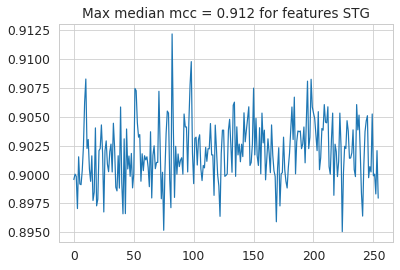

In [62]:
median_mccs = [np.median(i) for i in all_mccs]
plt.plot(median_mccs)
plt.title('Max median mcc = {} for features {}'.format(round(max(median_mccs), 3),\
           ''.join(list(powerset('QHPSTGAM'))[1:][np.argmax(median_mccs)])));

In [68]:
test_df = pd.DataFrame()
for i, v in enumerate(list(powerset('QHPSTGAM'))[1:]):
    test_df[''.join(v)] = all_mccs[i]

In [73]:
test_df.to_pickle('results/choosingAA.pkl.gz')

In [3]:
test_df = pd.read_pickle('results/choosingAA.pkl.gz')